In [1]:
import os
import random
import shutil

# Paths to your dataset directories
data_dir = "/kaggle/input/deepfake-and-real-images/Dataset"  # Update with your dataset directory path
train_real_dir = os.path.join(data_dir, "Train", "Real")
train_fake_dir = os.path.join(data_dir, "Train", "Fake")
val_real_dir = os.path.join(data_dir, "Validation", "Real")
val_fake_dir = os.path.join(data_dir, "Validation", "Fake")

# Define target directories for the reduced dataset
reduced_data_dir = "/kaggle/working/reduced_dataset"
reduced_train_real_dir = os.path.join(reduced_data_dir, "train", "real")
reduced_train_fake_dir = os.path.join(reduced_data_dir, "train", "fake")
reduced_val_real_dir = os.path.join(reduced_data_dir, "validation", "real")
reduced_val_fake_dir = os.path.join(reduced_data_dir, "validation", "fake")

# Create target directories if they don't exist
os.makedirs(reduced_train_real_dir, exist_ok=True)
os.makedirs(reduced_train_fake_dir, exist_ok=True)
os.makedirs(reduced_val_real_dir, exist_ok=True)
os.makedirs(reduced_val_fake_dir, exist_ok=True)

# Set desired number of images
train_size_real, train_size_fake = 17500, 17500
val_size_real, val_size_fake = 7500, 7500

# Helper function to sample and copy images
def sample_and_copy(src_dir, dest_dir, sample_size):
    images = os.listdir(src_dir)
    sampled_images = random.sample(images, sample_size)
    for img in sampled_images:
        shutil.copy(os.path.join(src_dir, img), dest_dir)

# Sample images for training and validation
sample_and_copy(train_real_dir, reduced_train_real_dir, train_size_real)
sample_and_copy(train_fake_dir, reduced_train_fake_dir, train_size_fake)
sample_and_copy(val_real_dir, reduced_val_real_dir, val_size_real)
sample_and_copy(val_fake_dir, reduced_val_fake_dir, val_size_fake)

print("Dataset reduced and copied successfully!")

Dataset reduced and copied successfully!


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

In [4]:
# Enable mixed precision for faster computation
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [5]:
# Model definition and training setup
IMG_SIZE = (456, 456)
BATCH_SIZE = 32  # Adjust based on memory availability

# Paths to data
train_data_dir = '/kaggle/working/reduced_dataset/train'
validation_data_dir = '/kaggle/working/reduced_dataset/validation'

# Data Generators with rescaling
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)
validation_generator = val_datagen.flow_from_directory(
    validation_data_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)

Found 35000 images belonging to 2 classes.
Found 15000 images belonging to 2 classes.


In [8]:
# EfficientNetB5 model setup
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(456, 456, 3))
base_model.trainable = False

# Define the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
tensorboard = TensorBoard(log_dir='./logs')

In [9]:
# Initial Training with frozen base model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_scheduler, tensorboard]
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730992672.859628     110 service.cc:145] XLA service 0x7a9d3c0a84a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730992672.859691     110 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730992672.859697     110 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730992751.966874     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.5063 - loss: 0.9730

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 565s 417ms/step - accuracy: 0.5063 - loss: 0.9729 - val_accuracy: 0.5061 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 367s 334ms/step - accuracy: 0.5074 - loss: 0.7001 - val_accuracy: 0.4991 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 367s 334ms/step - accuracy: 0.5011 - loss: 0.6967 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 4/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 367s 334ms/step - accuracy: 0.4973 - loss: 0.6960 - val_accuracy: 0.4943 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 5/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 382s 334ms/step - accuracy: 0.4959 - loss: 0.6938 - val_accuracy: 0.4995 - val_loss: 0.6932 - learning_rate: 5.0000e-04
Epoch 6/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 382s 335ms/step - accuracy: 0.5023 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 5.0000e-04


In [10]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

469/469 ━━━━━━━━━━━━━━━━━━━━ 110s 234ms/step - accuracy: 0.5078 - loss: 0.6930
Validation Loss: 0.6929761171340942
Validation Accuracy: 0.5060666799545288


In [11]:
# Fine-tuning phase
base_model.trainable = True  # Unfreeze for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    epochs=20,  # Increase if model benefits from more epochs
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_scheduler, tensorboard]
)

Epoch 1/20


2024-11-07 16:10:17.191849: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[32,229,229,144]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,231,231,144]{3,2,1,0}, f16[144,3,3,1]{3,2,1,0}), window={size=3x3}, dim_labels=b01f_o01i->b01f, feature_group_count=144, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-07 16:10:18.418623: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.226947939s
Trying algorithm eng0{} for conv (f16[32,229,229,144]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,231,231,144]{3,2,1,0}, f16[144,3,3,1]{3,2,1,0}), window={size=3x3}, dim_labels=b01f_o01i->b01f, feature_group_count=144, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queue

 627/1094 ━━━━━━━━━━━━━━━━━━━━ 7:52 1s/step - accuracy: 0.6689 - loss: 0.6036

2024-11-07 16:25:38.241803: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[24,229,229,144]{3,2,1,0}, u8[0]{0}) custom-call(f16[24,231,231,144]{3,2,1,0}, f16[144,3,3,1]{3,2,1,0}), window={size=3x3}, dim_labels=b01f_o01i->b01f, feature_group_count=144, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-07 16:25:38.914560: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.672852752s
Trying algorithm eng0{} for conv (f16[24,229,229,144]{3,2,1,0}, u8[0]{0}) custom-call(f16[24,231,231,144]{3,2,1,0}, f16[144,3,3,1]{3,2,1,0}), window={size=3x3}, dim_labels=b01f_o01i->b01f, feature_group_count=144, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queue

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1886s 1s/step - accuracy: 0.7349 - loss: 0.5114 - val_accuracy: 0.9312 - val_loss: 0.1663 - learning_rate: 1.0000e-05
Epoch 2/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1205s 1s/step - accuracy: 0.9587 - loss: 0.1106 - val_accuracy: 0.9546 - val_loss: 0.1156 - learning_rate: 1.0000e-05
Epoch 3/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1195s 1s/step - accuracy: 0.9750 - loss: 0.0695 - val_accuracy: 0.9627 - val_loss: 0.0985 - learning_rate: 1.0000e-05
Epoch 4/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1192s 1s/step - accuracy: 0.9789 - loss: 0.0544 - val_accuracy: 0.9667 - val_loss: 0.0886 - learning_rate: 1.0000e-05
Epoch 5/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1192s 1s/step - accuracy: 0.9854 - loss: 0.0427 - val_accuracy: 0.9699 - val_loss: 0.0910 - learning_rate: 1.0000e-05
Epoch 6/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1190s 1s/step - accuracy: 0.9874 - loss: 0.0340 - val_accuracy: 0.9700 - val_loss: 0.0981 - learning_rate: 1.0000e-05
Epoch 7/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1188s 1s/

In [13]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

469/469 ━━━━━━━━━━━━━━━━━━━━ 112s 237ms/step - accuracy: 0.9689 - loss: 0.0865
Validation Loss: 0.08864030987024307
Validation Accuracy: 0.9667333364486694


In [19]:
model.save("/kaggle/working/model_efficientb5.keras")

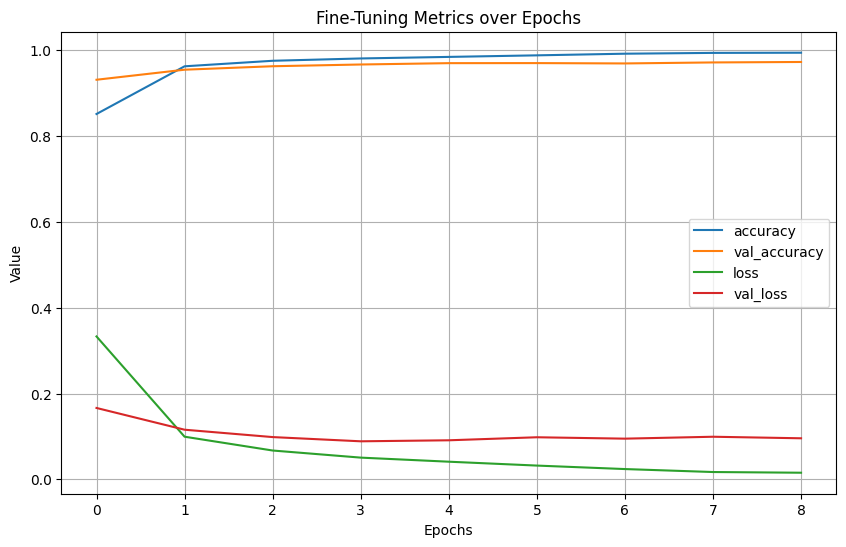

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert fine-tuning history to DataFrame
fine_tune_history_df = pd.DataFrame(fine_tune_history.history)

# Plot the fine-tuning metrics
fine_tune_history_df[['accuracy', 'val_accuracy', 'loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Fine-Tuning Metrics over Epochs")
plt.show()

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the test dataset
test_data_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Test"

# ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling, no augmentation for testing

# Test data generator
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(456, 456),  # Use the same image size used for training
    batch_size=32,
    class_mode='binary',  # Since we have two classes: real and fake
    shuffle=False  # Shuffle should be False for evaluation
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Found 10905 images belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


341/341 ━━━━━━━━━━━━━━━━━━━━ 140s 409ms/step - accuracy: 0.9397 - loss: 0.1539
Test Loss: 0.3071, Test Accuracy: 0.8815


341/341 ━━━━━━━━━━━━━━━━━━━━ 76s 222ms/step


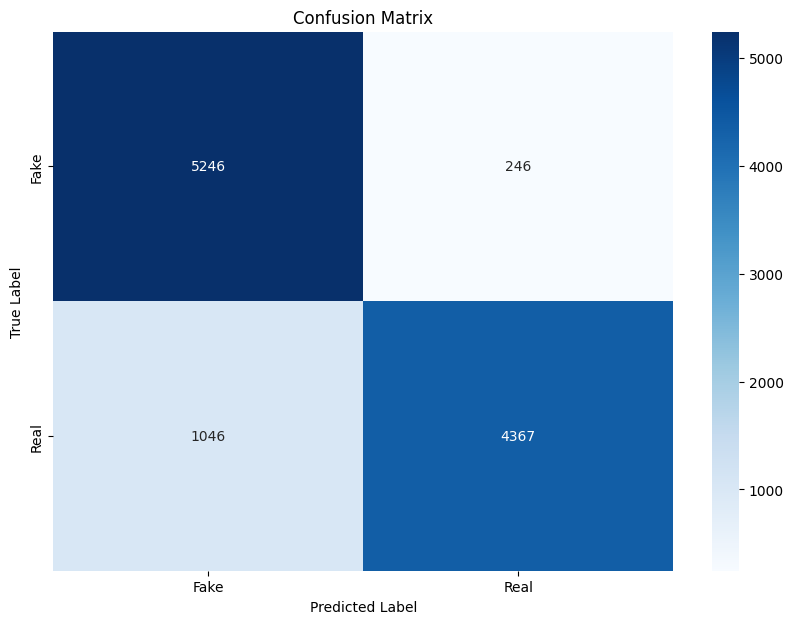

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")  # Convert probabilities to binary labels

# Get true labels
true_classes = test_generator.classes  # True labels
class_labels = list(test_generator.class_indices.keys())  # Class labels: ['fake', 'real']

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()